<a href="https://colab.research.google.com/github/dh-anna/Recommending-system/blob/Bipartile_graph/Recommending_system1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

url = "https://files.grouplens.org/datasets/movielens/ml-25m.zip"
with urlopen(url) as zurl:
  with ZipFile(BytesIO(zurl.read())) as zfile:
    zfile.extractall('.')

In [ ]:
import pandas as pd

ratings = pd.read_csv("/content/ml-25m/ratings.csv", encoding='UTF-8')
tags = pd.read_csv("/content/ml-25m/tags.csv", encoding='UTF-8')
links = pd.read_csv("/content/ml-25m/links.csv", encoding='UTF-8')
movies = pd.read_csv("/content/ml-25m/movies.csv", encoding='UTF-8')
genome_scores = pd.read_csv("/content/ml-25m/genome-scores.csv", encoding='UTF-8')
genome_tags = pd.read_csv("/content/ml-25m/genome-tags.csv", encoding="UTF-8")

In [ ]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
62418,209157,We (2018),Drama
62419,209159,Window of the Soul (2001),Documentary
62420,209163,Bad Poems (2018),Comedy|Drama
62421,209169,A Girl Thing (2001),(no genres listed)


<Axes: xlabel='rating', ylabel='count'>

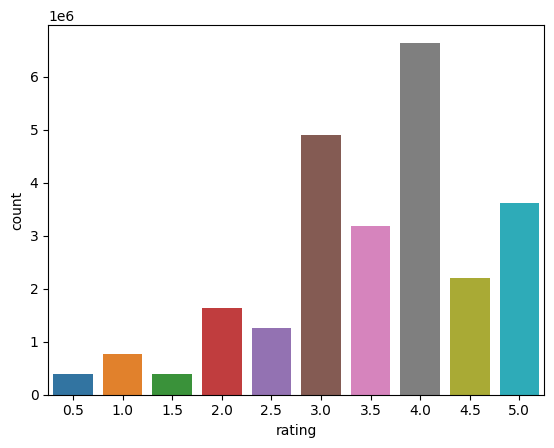

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot (x=ratings['rating'])

Text(0, 0.5, 'Count')

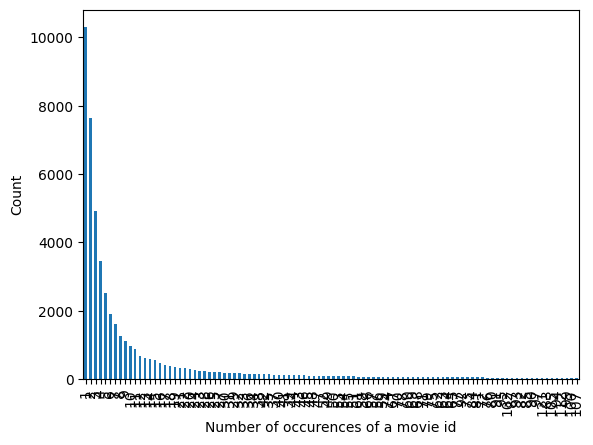

In [ ]:
rated_movie_counts = ratings.groupby('movieId').size()
count_occurrences = rated_movie_counts.value_counts()
count_occurrences[:100].plot(kind='bar')
plt.xlabel("Number of occurences of a movie id")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

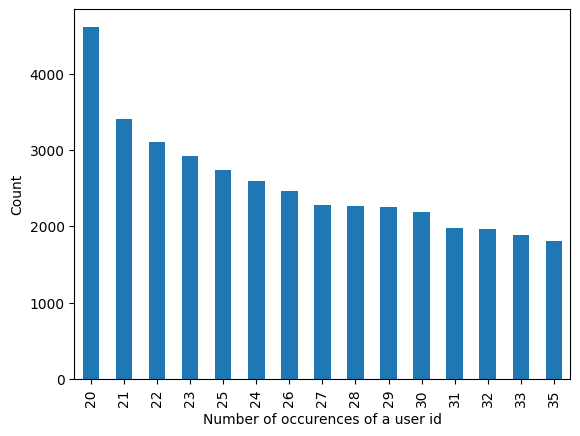

In [ ]:
userid_counts = ratings.groupby('userId').size()
count_occurrences = userid_counts.value_counts()
count_occurrences[:15].plot(kind='bar')
plt.xlabel("Number of occurences of a user id")
plt.ylabel("Count")

In [ ]:
!pip install torch-geometric --quiet
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn.functional as F
from torch import nn, optim, Tensor
from torch_geometric.utils import structured_negative_sampling
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn import LGConv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.8 MB/s eta 0:00:00


In [ ]:
df = pd.read_csv("/content/ml-25m/ratings.csv", encoding='UTF-8')
df = df.loc[df['movieId'].isin(movies['movieId'].unique())]

In [ ]:
df

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510
...,...,...,...,...
25000090,162541,50872,4.5,1240953372
25000091,162541,55768,2.5,1240951998
25000092,162541,56176,2.0,1240950697
25000093,162541,58559,4.0,1240953434


Csak a magas értékeléseket tartjuk meg

In [ ]:
df = df[df['rating']>=4].iloc[:100000]

A userek és a filmek, amik ratingelve voltak

In [ ]:
user_mapping = {userid: i for i, userid in enumerate(df['userId'].unique())}
movie_mapping = {movieid: i for i, movieid in enumerate(df['movieId'].unique())}

In [ ]:
num_users = len(user_mapping)
num_movies = len(movie_mapping)
num_total = num_users + num_movies
print(num_users)
print(num_movies)

1387
8682


In [ ]:
user_ids = torch.LongTensor([user_mapping[i] for i in df['userId']])
user_movie_rating = torch.LongTensor(df['rating'])
movie_ids = torch.LongTensor([movie_mapping[i] for i in df['movieId']])
edge_index = torch.stack((user_ids, movie_ids))

In [ ]:
user_ids

tensor([   0,    0,    0,  ..., 1386, 1386, 1386])

In [ ]:
edge_index

tensor([[   0,    0,    0,  ..., 1386, 1386, 1386],
        [   0,    1,    2,  ..., 3115,   75,  625],
        [   5,    5,    5,  ...,    4,    4,    4]])

In [ ]:
train_index, test_index = train_test_split(range(len(df)), test_size=0.2, random_state=0)
val_index, test_index = train_test_split(test_index, test_size=0.5, random_state=0)

train_edge_index = edge_index[:, train_index]
val_edge_index = edge_index[:, val_index]
test_edge_index = edge_index[:, test_index]

In [ ]:
def sample_mini_batch(edge_index):
    # Generate BATCH_SIZE random indices
    index = np.random.choice(range(edge_index.shape[1]), size=BATCH_SIZE)

    # Generate negative sample indices
    edge_index = structured_negative_sampling(edge_index)
    edge_index = torch.stack(edge_index, dim=0)

    user_index = edge_index[0, index]
    pos_item_index = edge_index[1, index]
    neg_item_index = edge_index[2, index]

    return user_index, pos_item_index, neg_item_index

In [ ]:
class LightGCN(nn.Module):
    def __init__(self, num_users, num_items, num_layers=4, dim_h=64):
        super().__init__()

        self.num_users = num_users
        self.num_items = num_items
        self.num_layers = num_layers
        self.emb_users = nn.Embedding(num_embeddings=self.num_users, embedding_dim=dim_h)
        self.emb_items = nn.Embedding(num_embeddings=self.num_items, embedding_dim=dim_h)

        self.convs = nn.ModuleList(LGConv() for _ in range(num_layers))

        nn.init.normal_(self.emb_users.weight, std=0.01)
        nn.init.normal_(self.emb_items.weight, std=0.01)

    def forward(self, edge_index):
        emb = torch.cat([self.emb_users.weight, self.emb_items.weight])
        embs = [emb]

        for conv in self.convs:
            emb = conv(x=emb, edge_index=edge_index)
            embs.append(emb)

        emb_final = 1/(self.num_layers+1) * torch.mean(torch.stack(embs, dim=1), dim=1)

        emb_users_final, emb_items_final = torch.split(emb_final, [self.num_users, self.num_items])

        return emb_users_final, self.emb_users.weight, emb_items_final, self.emb_items.weight

In [ ]:
def bpr_loss(emb_users_final, emb_users, emb_pos_items_final, emb_pos_items, emb_neg_items_final, emb_neg_items):
    reg_loss = LAMBDA * (emb_users.norm().pow(2) +
                        emb_pos_items.norm().pow(2) +
                        emb_neg_items.norm().pow(2))

    pos_ratings = torch.mul(emb_users_final, emb_pos_items_final).sum(dim=-1)
    neg_ratings = torch.mul(emb_users_final, emb_neg_items_final).sum(dim=-1)

    bpr_loss = torch.mean(torch.nn.functional.softplus(pos_ratings - neg_ratings))
    # bpr_loss = torch.mean(torch.nn.functional.logsigmoid(pos_ratings - neg_ratings))

    return -bpr_loss + reg_loss

In [ ]:
def get_user_items(edge_index):
    user_items = dict()
    for i in range(edge_index.shape[1]):
        user = edge_index[0][i].item()
        item = edge_index[1][i].item()
        if user not in user_items:
            user_items[user] = []
        user_items[user].append(item)
    return user_items

In [ ]:
def compute_recall_at_k(movies_ground_truth, movies_predicted):
    num_correct_pred = np.sum(movies_predicted, axis=1)
    num_total_pred = np.array([len(movies_ground_truth[i]) for i in range(len(movies_ground_truth))])

    recall = np.mean(num_correct_pred / num_total_pred)

    return recall

In [ ]:
def compute_ndcg_at_k(movies_ground_truth, movies_predicted):
    test_matrix = np.zeros((len(movies_predicted), K))

    for i, movies in enumerate(movies_ground_truth):
        length = min(len(movies), K)
        test_matrix[i, :length] = 1

    max_r = test_matrix
    idcg = np.sum(max_r * 1. / np.log2(np.arange(2, K + 2)), axis=1)
    dcg = movies_predicted * (1. / np.log2(np.arange(2, K + 2)))
    dcg = np.sum(dcg, axis=1)
    idcg[idcg == 0.] = 1.
    ndcg = dcg / idcg
    ndcg[np.isnan(ndcg)] = 0.

    return np.mean(ndcg)

In [ ]:
def get_metrics(model, edge_index, exclude_edge_indices):

    ratings = torch.matmul(model.emb_users.weight, model.emb_items.weight.T)

    for exclude_edge_index in exclude_edge_indices:
        user_pos_items = get_user_items(exclude_edge_index)
        exclude_users = []
        exclude_items = []
        for user, items in user_pos_items.items():
            exclude_users.extend([user] * len(items))
            exclude_items.extend(items)
        ratings[exclude_users, exclude_items] = -1024

    # get the top k recommended items for each user
    _, top_K_items = torch.topk(ratings, k=K)

    # get all unique users in evaluated split
    users = edge_index[0].unique()

    test_user_pos_items = get_user_items(edge_index)

    # convert test user pos items dictionary into a list
    test_user_pos_items_list = [test_user_pos_items[user.item()] for user in users]

    # determine the correctness of topk predictions
    items_predicted = []
    for user in users:
        ground_truth_items = test_user_pos_items[user.item()]
        label = list(map(lambda x: x in ground_truth_items, top_K_items[user]))
        items_predicted.append(label)

    recall = compute_recall_at_k(test_user_pos_items_list, items_predicted)
    ndcg = compute_ndcg_at_k(test_user_pos_items_list, items_predicted)

    return recall, ndcg

In [ ]:
# wrapper function to evaluate model
def test(model, edge_index, exclude_edge_indices):
    emb_users_final, emb_users, emb_items_final, emb_items = model.forward(edge_index)
    user_indices, pos_item_indices, neg_item_indices = structured_negative_sampling(edge_index, contains_neg_self_loops=False)

    emb_users_final, emb_users = emb_users_final[user_indices], emb_users[user_indices]

    emb_pos_items_final, emb_pos_items = emb_items_final[pos_item_indices], emb_items[pos_item_indices]
    emb_neg_items_final, emb_neg_items = emb_items_final[neg_item_indices], emb_items[neg_item_indices]

    loss = bpr_loss(emb_users_final, emb_users, emb_pos_items_final, emb_pos_items, emb_neg_items_final, emb_neg_items).item()

    recall, ndcg = get_metrics(model, edge_index, exclude_edge_indices)

    return loss, recall, ndcg

In [ ]:
K = 20
LAMBDA = 1e-6
BATCH_SIZE = 1024

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
model = LightGCN(num_users, num_movies)
model = model.to(device)
edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
val_edge_index = val_edge_index.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
print(model)

LightGCN(
  (emb_users): Embedding(1387, 64)
  (emb_items): Embedding(8682, 64)
  (convs): ModuleList(
    (0-3): 4 x LGConv()
  )
)


In [ ]:
int(len(train_index)/BATCH_SIZE)

78

In [ ]:
%%time

from tqdm.auto import tqdm

n_batch = int(len(train_index) / BATCH_SIZE)

for epoch in tqdm(range(31)):
    model.train()

    for _ in tqdm(range(n_batch)):
      optimizer.zero_grad()

      emb_users_final, emb_users, emb_items_final, emb_items = model.forward(train_edge_index)

      #print(emb_users_final.shape)
      #print(emb_users.shape)
      #print(emb_items_final.shape)
      #print(emb_items.shape)

      user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(train_edge_index)

      #print(user_indices.shape)
      #print(pos_item_indices.shape)
      #print(neg_item_indices.shape)

      emb_users_final, emb_users = emb_users_final[user_indices], emb_users[user_indices]
      emb_pos_items_final, emb_pos_items = emb_items_final[pos_item_indices], emb_items[pos_item_indices]
      emb_neg_items_final, emb_neg_items = emb_items_final[neg_item_indices], emb_items[neg_item_indices]

      train_loss = bpr_loss(emb_users_final, emb_users, emb_pos_items_final, emb_pos_items, emb_neg_items_final, emb_neg_items)

      train_loss.backward()
      optimizer.step()

    if epoch % 5 == 0:
        model.eval()
        val_loss, recall, ndcg = test(model, val_edge_index, [train_edge_index])
        print(f"Epoch {epoch} | Train loss: {train_loss.item():.5f} | Val loss: {val_loss:.5f} | Val recall@{K}: {recall:.5f} | Val ndcg@{K}: {ndcg:.5f}")

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 0 | Train loss: -0.69753 | Val loss: -0.68799 | Val recall@20: 0.13891 | Val ndcg@20: 0.09774


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 5 | Train loss: -1.22801 | Val loss: -0.32461 | Val recall@20: 0.13711 | Val ndcg@20: 0.09651


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 10 | Train loss: -3.12254 | Val loss: 0.47199 | Val recall@20: 0.13935 | Val ndcg@20: 0.09825


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 15 | Train loss: -5.98615 | Val loss: 1.46458 | Val recall@20: 0.13842 | Val ndcg@20: 0.09875


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 20 | Train loss: -9.42974 | Val loss: 2.62369 | Val recall@20: 0.13788 | Val ndcg@20: 0.09842


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 25 | Train loss: -13.82323 | Val loss: 4.02235 | Val recall@20: 0.13786 | Val ndcg@20: 0.09875


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 30 | Train loss: -18.73551 | Val loss: 5.48013 | Val recall@20: 0.13761 | Val ndcg@20: 0.09837
CPU times: user 10min 39s, sys: 6.16 s, total: 10min 45s
Wall time: 11min 15s


In [ ]:
model_path = 'my_model.pth'

# Save the model's state dictionary to the specified file
torch.save(model.state_dict(), model_path)

# Optionally, you can save additional information, such as optimizer state, if needed
# For example, to save the optimizer's state dictionary:
optimizer_path = 'my_optimizer.pth'
torch.save(optimizer.state_dict(), optimizer_path)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/Recommending-system/
!git comit -am "Initial recommending system without edge weights"

/content/Recommending-system
Already up to date.


In [ ]:
test_loss, test_recall, test_ndcg = test(model, test_edge_index.to(device), [train_edge_index, val_edge_index])

print(f"Test loss: {test_loss:.5f} | Test recall@{K}: {test_recall:.5f} | Test ndcg@{K}: {test_ndcg:.5f}")

Test loss: 5.81729 | Test recall@20: 0.14235 | Test ndcg@20: 0.10360


In [ ]:
model = LightGCN(1387, 8682)
model.load_state_dict(torch.load('my_model.pth'))
optimizer.load_state_dict(torch.load('my_optimizer.pth'))

In [ ]:
movieId_title = pd.Series(movies['title'].values, index=movies.movieId).to_dict()
#movieid_author = pd.Series(movies['Book-Author'].values, index=movies.ISBN).to_dict()
user_pos_items = get_user_items(edge_index)

In [ ]:
from PIL import Image
import requests

def recommend(user_id, num_recs):
    user = user_mapping[user_id]
    emb_user = model.emb_users.weight[user]
    ratings = model.emb_items.weight @ emb_user

    values, indices = torch.topk(ratings, k=100)

    ids = [index.cpu().item() for index in indices if index in user_pos_items[user]][:num_recs]
    item_movieId = [list(movie_mapping.keys())[list(movie_mapping.values()).index(movie)] for movie in ids]
    titles = [movieId_title[id] for id in item_movieId]
    #authors = [bookid_author[id] for id in item_isbns]

    print(f'Favorite movies from user n°{user_id}:')
    for i in range(len(item_movieId )):
        print(f'- {titles[i]}')

    ids = [index.cpu().item() for index in indices if index not in user_pos_items[user]][:num_recs]
    item_movieId = [list(movie_mapping.keys())[list(movie_mapping.values()).index(movie)] for movie in ids]
    titles = [movieId_title[id] for id in item_movieId]
    #authors = [bookid_author[id] for id in item_isbns]

    print(f'\nRecommended books for user n°{user_id}')
    for i in range(num_recs):
        print(f'- {titles[i]}')

    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
    fig, axs = plt.subplots(1, num_recs, figsize=(20,6))
    fig.patch.set_alpha(0)
    for i, title in enumerate(titles):
        url = movies.loc[movies['title'] == title]['Image-URL-L'][:1].values[0]
        #img = Image.open(requests.get(url, stream=True, headers=headers).raw)
        rating = df.loc[df['movieId'] == movies.loc[movies['title'] == title]['movieId'][:1].values[0]]['rating'].mean()
        axs[i].axis("off")
        axs[i].imshow(img)
        axs[i].set_title(f'{rating:.1f}/10', y=-0.1, fontsize=18)

Favorite movies from user n°6:
- Shawshank Redemption, The (1994)
- Star Wars: Episode IV - A New Hope (1977)
- Schindler's List (1993)
- Silence of the Lambs, The (1991)
- Star Wars: Episode V - The Empire Strikes Back (1980)
- Godfather, The (1972)
- Fargo (1996)

Recommended books for user n°6
- Pulp Fiction (1994)
- Forrest Gump (1994)
- Matrix, The (1999)
- Fight Club (1999)
- Usual Suspects, The (1995)
- Terminator 2: Judgment Day (1991)
- Braveheart (1995)


KeyError: ignored

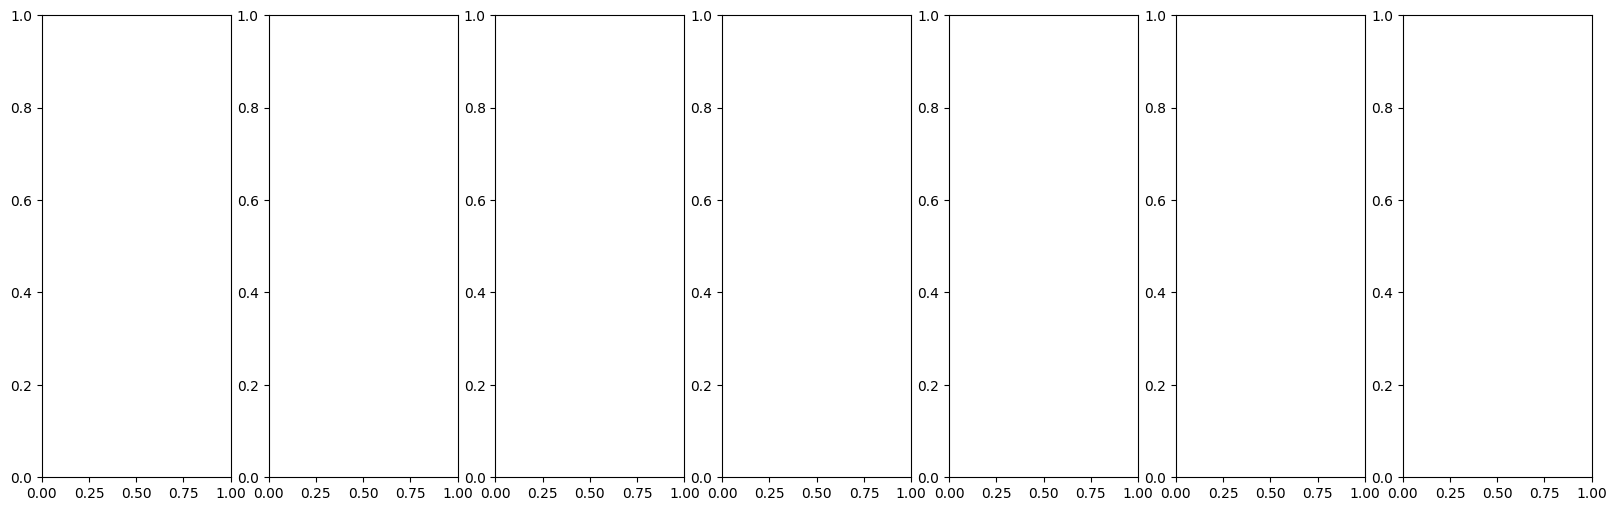

In [ ]:
recommend(6, 7)